# 加载信标

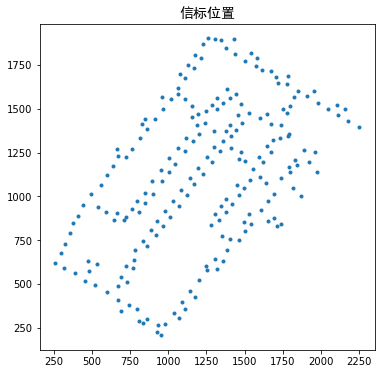

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager

fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

beacon = []

with open("蓝牙信标数据（完善）.txt") as f:
    data = f.readlines()
    index = 0
    for i in range(len(data)):
        data[i] = data[i].rstrip("\n")
        splits = data[i].split(',')
        #print(splits)
        if ( len(splits)<5 ):
            continue
        else:
            beacon.append(splits)
            
#print(beacon)
Beacon_xy = np.zeros((len(beacon),2))
for i in range(Beacon_xy.shape[0]):
    Beacon_xy[i,0] = beacon[i][3]
    Beacon_xy[i,1] = beacon[i][4]

plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("信标位置", fontproperties=fontP)
plt.show()

# 加载实时信标

In [2]:
import json

time_seq_beacon = []
time_seq_compass = []
time_seq_accelerometer = []
time_seq_deviceMotion = []
beacon_seq = []
compass_seq = []
accelerometer_seq = []
deviceMotion_seq = []
with open("实际采集蓝牙数据.txt") as f:
    lines = f.readlines()
    #print(data)
    #json.loads(data[0])
    for line in lines:
        res_sparse = json.loads(line)
        #print (a)
        time_samples_beacon = []
        time_samples_compass = []
        time_samples_accelerometer = []
        time_samples_deviceMotion = []
        beacon_response = []
        compass_samples = []
        accelerometer_samples = []
        deviceMotion_samples = []
        for res in res_sparse:
            #解析信标
            if res['type'] == 'ibeacon':
                for one_beacon in res['res']:
                    beacon_response.append(one_beacon)
                    time_samples_beacon.append(res['timestamp'])
            if res['type'] == 'compass':
                #解析罗盘
                compass_samples.append(res['res'])
                time_samples_compass.append(res['timestamp'])
            if res['type'] == 'accelerometer':
                #解析加速器
                data = res['res']
                accelerometer_samples.append(np.sqrt(data[0]*data[0]+data[1]*data[1]+data[2]*data[2]))
                time_samples_accelerometer.append(res['timestamp'])
            if res['type'] == 'deviceMotion':
                #解析设备方向
                deviceMotion_samples.append(res['res'])
                time_samples_deviceMotion.append(res['timestamp'])
        beacon_seq.append(beacon_response)
        time_seq_beacon.append(time_samples_beacon)
        compass_seq.append(compass_samples)
        time_seq_compass.append(time_samples_compass)
        accelerometer_seq.append(accelerometer_samples)
        time_seq_accelerometer.append(time_samples_accelerometer)
        deviceMotion_seq.append(deviceMotion_samples)
        time_seq_deviceMotion.append(time_samples_deviceMotion)


# 显示距离与强度的关系

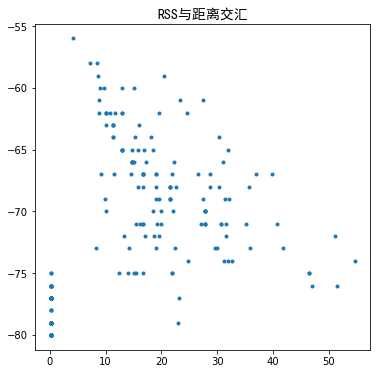

In [3]:
RSS = []
dist = []
for seq in beacon_seq:
    for beacon_res in seq:
        #print(beacon_res)
        if beacon_res[3] < -80 or beacon_res[4] < 0.1:
            continue
        RSS.append(beacon_res[3])
        dist.append(beacon_res[4])
        break
plt.figure(figsize=(6,6))
plt.plot(dist,RSS,'.')
plt.title("RSS与距离交汇", fontproperties=fontP)
plt.show()

# 几何法求解（梯度下降法）

In [4]:
def Distance2D(Array_point,location):
    if Array_point.shape[1] !=2 or location.shape[1] != 2:
        print("不是二维点")
        return
    return np.array([np.sqrt((i[0]-location[0,0])**2 +(i[1]-location[0,1])**2)   for i in Array_point])

def LOSS(Array_point,location,distance):
    location = np.reshape(location,(1,2))
    curdistance = Distance2D(Array_point , location)
    #print(curdistance)
    for i in range(len(distance)):
        curdistance[i] = np.sqrt( (curdistance[i]-distance[i])**2 )
    return np.sum(curdistance)
def SGDS(points,distance,learnration=0.01, max_iter_count=300,axis='x',init=[0,0]):
    if points.shape[0] !=3 or distance.shape[0] != 3:
        print("不是三个点")
        return
    loss_global = [0,0,0]    
    eval = np.zeros((3,2))
    for i in range(3):
        iter_list=np.zeros((max_iter_count,2))
        iter_list[0,0] = points[i,0]
        iter_list[0,1] = points[i,1]
        loss_list=np.zeros(max_iter_count)
        iter_count = 0
        loss = 0
        loss_Last=1

        #当迭代此时小于最大迭代次数时，进行
        while  iter_count < max_iter_count-1:        
        #print(str(iter_count)+'  location:'+str(iter_list[iter_count])+ '  loss'+str(loss))
            loss = LOSS(points,iter_list[iter_count],distance)
            loss_list[iter_count] = loss
            loss_Last = loss
            iter_count += 1
            if (points[0,0]-iter_list[iter_count-1,0])**2 + (points[0,1]-iter_list[iter_count-1,1])**2 - distance[0]**2>=0:
                iter_list[iter_count,0] += iter_list[iter_count-1,0] + learnration* (points[0,0]-iter_list[iter_count-1,0])
                iter_list[iter_count,1] += iter_list[iter_count-1,1] + learnration* (points[0,1]-iter_list[iter_count-1,1])
            else:
                iter_list[iter_count,0] += iter_list[iter_count-1,0] - learnration* (points[0,0]-iter_list[iter_count-1,0])
                iter_list[iter_count,1] += iter_list[iter_count-1,1] - learnration* (points[0,1]-iter_list[iter_count-1,1])                
            if (points[1,0]-iter_list[iter_count-1,0])**2 + (points[1,1]-iter_list[iter_count-1,1])**2 - distance[1]**2>=0:
                iter_list[iter_count,0] +=   learnration* (points[1,0]-iter_list[iter_count-1,0])
                iter_list[iter_count,1] +=   learnration* (points[1,1]-iter_list[iter_count-1,1])
            else:
                iter_list[iter_count,0] +=  - learnration* (points[1,0]-iter_list[iter_count-1,0])
                iter_list[iter_count,1] +=  - learnration* (points[1,1]-iter_list[iter_count-1,1])
            if (points[2,0]-iter_list[iter_count-1,0])**2 + (points[2,1]-iter_list[iter_count-1,1])**2 - distance[2]**2>=0:
                iter_list[iter_count,0] +=   learnration* (points[2,0]-iter_list[iter_count-1,0])
                iter_list[iter_count,1] +=   learnration* (points[2,1]-iter_list[iter_count-1,1]) 
            else:
                iter_list[iter_count,0] +=  - learnration* (points[2,0]-iter_list[iter_count-1,0])
                iter_list[iter_count,1] +=  - learnration* (points[2,1]-iter_list[iter_count-1,1])             

            loss = LOSS(points,iter_list[iter_count],distance)

        minindex = np.argmin(loss_list[0:-1])
        loss_global[i]=(loss_list[minindex])
        eval[i,0] = iter_list[minindex,0]
        eval[i,1] = iter_list[minindex,1]
        #print("迭代位置："+str(minindex))
    minindex = loss_global.index(min(loss_global))
    #print(str(loss_global)+" "+ str(minindex))
    return eval[minindex], loss_global[minindex]    

In [5]:
#根据uid等索引得到信标坐标
def Convert(lst):
    unpack = []
    for i in lst:
        unpack.extend(i)
    res_dct = {unpack[i]+'_'+unpack[i+1]+'_'+unpack[i+2]: unpack[i+3:i+5] for i in range(0, len(unpack), 5)}
    return res_dct
def GetXY(dct,uid):
    try:
        XY = dct[uid]
        return [float(i) for i in XY]
    except KeyError:
        return -1

In [6]:
beacon_dic = Convert(beacon)

# 测试集测试

# #1加权定位

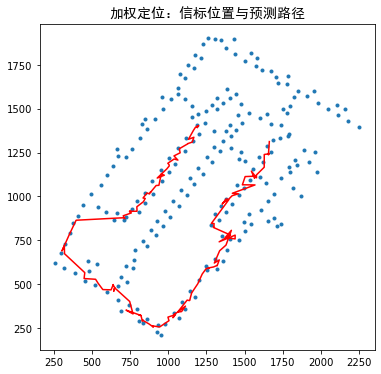

In [157]:
import json

def SumWeightLoc(points,distance):    
    if points.shape[0] !=3 or distance.shape[0] != 3:
        print("不是三个点")
        return
    reverse_dis = 1/distance
    weights = reverse_dis/np.sum(reverse_dis)
    return (points[0,:]*weights[0]+points[1,:]*weights[1]+points[2,:]*weights[2])
# 将step按RSS排序
def takeRSS(elem):
    return elem[3]
res_loc = []
for step in beacon_seq:
    cur_step = []
    for one_beacon in step:
        if GetXY(beacon_dic,one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2])) != -1 :
            cur_step.append(one_beacon)
            #print(one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2]))
            
    if len(cur_step) < 3:
        #print('点过少，跳过')
        continue

    elif len(cur_step) == 3:
        distance = np.zeros(3)
        points = np.ones((3,2))
        distance[0] = cur_step[0][4]
        distance[1] = cur_step[1][4]
        distance[2] = cur_step[2][4]
        points[0] = GetXY(beacon_dic,cur_step[0][0].lower()+'_'+str(cur_step[0][1])+'_'+str(cur_step[0][2]))
        points[1] = GetXY(beacon_dic,cur_step[1][0].lower()+'_'+str(cur_step[1][1])+'_'+str(cur_step[1][2]))
        points[2] = GetXY(beacon_dic,cur_step[2][0].lower()+'_'+str(cur_step[2][1])+'_'+str(cur_step[2][2]))
        res_loc.append(SumWeightLoc(points,distance))
    elif len(cur_step) >3:       
        step.sort(key=takeRSS,reverse = True)       
        sort3 = cur_step[0:3]
        distance = np.zeros(3)
        points = np.zeros((3,2))
        distance[0] = sort3[0][4]
        distance[1] = sort3[1][4]
        distance[2] = sort3[2][4]
        points[0] = GetXY(beacon_dic,sort3[0][0].lower()+'_'+str(sort3[0][1])+'_'+str(sort3[0][2]))
        points[1] = GetXY(beacon_dic,sort3[1][0].lower()+'_'+str(sort3[1][1])+'_'+str(sort3[1][2]))
        points[2] = GetXY(beacon_dic,sort3[2][0].lower()+'_'+str(sort3[2][1])+'_'+str(sort3[2][2]))
        res_loc.append(SumWeightLoc(points,distance))

    if(res_loc[-1][0]<5 and res_loc[-1][1]<5):
        print(step,end='')
        print(points,end='')
        print(distance)
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("加权定位：信标位置与预测路径", fontproperties=fontP)
res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r-')
plt.show()

# #2使用梯度下降3点定位

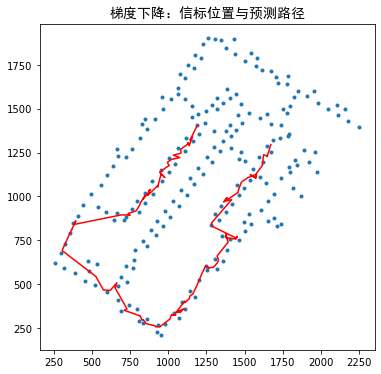

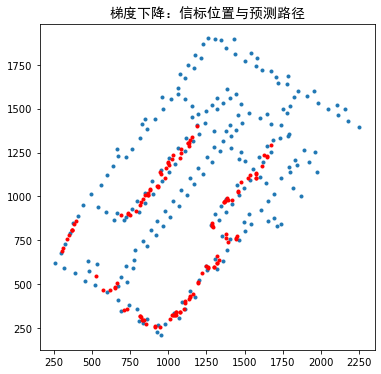

In [303]:
# 将step按RSS排序
def takeRSS(elem):
    return elem[3]
res_loc = []
for step in beacon_seq:
    cur_step = []
    for one_beacon in step:
        if GetXY(beacon_dic,one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2])) != -1 and one_beacon[3]>-75:
            cur_step.append(one_beacon)
            #print(one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2]))
            
    if len(cur_step) < 3:
        #print('点过少，跳过')
        continue

    elif len(cur_step) == 3:
        distance = np.zeros(3)
        points = np.ones((3,2))
        distance[0] = cur_step[0][4]
        distance[1] = cur_step[1][4]
        distance[2] = cur_step[2][4]
        points[0] = GetXY(beacon_dic,cur_step[0][0].lower()+'_'+str(cur_step[0][1])+'_'+str(cur_step[0][2]))
        points[1] = GetXY(beacon_dic,cur_step[1][0].lower()+'_'+str(cur_step[1][1])+'_'+str(cur_step[1][2]))
        points[2] = GetXY(beacon_dic,cur_step[2][0].lower()+'_'+str(cur_step[2][1])+'_'+str(cur_step[2][2]))
        eval, loss = SGDS(points,distance)
        res_loc.append([eval[0],eval[1]])
    elif len(cur_step) >3:       
        cur_step.sort(key=takeRSS,reverse = True)       
        sort3 = cur_step[0:3]
        distance = np.zeros(3)
        points = np.zeros((3,2))
        distance[0] = sort3[0][4]
        distance[1] = sort3[1][4]
        distance[2] = sort3[2][4]
        points[0] = GetXY(beacon_dic,sort3[0][0].lower()+'_'+str(sort3[0][1])+'_'+str(sort3[0][2]))
        points[1] = GetXY(beacon_dic,sort3[1][0].lower()+'_'+str(sort3[1][1])+'_'+str(sort3[1][2]))
        points[2] = GetXY(beacon_dic,sort3[2][0].lower()+'_'+str(sort3[2][1])+'_'+str(sort3[2][2]))
        eval, loss = SGDS(points,distance)
        res_loc.append([eval[0],eval[1]])

plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降：信标位置与预测路径", fontproperties=fontP)
res_loc_array_3p = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r-')
plt.show()  
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降：信标位置与预测路径", fontproperties=fontP)
#res_loc_array = np.array(res_loc)
plt.plot(res_loc_array_3p[:,0],res_loc_array_3p[:,1],'r.')
plt.show() 

# #3卡尔曼滤波

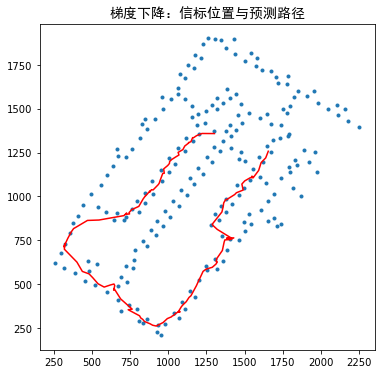

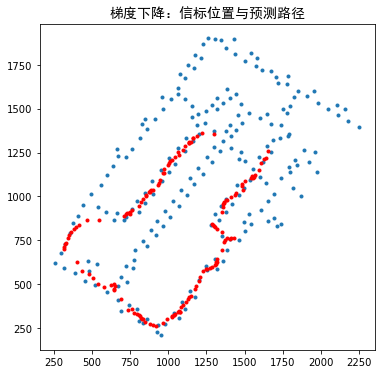

In [8]:
# 将step按RSS排序
def takeRSS(elem):
    return elem[3]
res_loc = []

evalkk=np.mat([[1637],[1219]])#当前卡尔曼估计值
evalkk1=np.mat([[1628],[1211]])#当前预测值
evalk1k1=np.mat([[0],[0]])#上一次卡尔曼估计值
Pkk=np.mat([[100,0],[0,100]])
Pkk1=np.mat([[100,0],[0,100]])
Pk1k1=np.mat([[100,0],[0,100]])
Q = np.mat([[100,0],[0,100]])
R = np.mat([[200,0],[0,200]])
kalman_T = []
#kalman_T[0] = np.copy(T[0])
T_obs = []
error = []

for step in beacon_seq:
    cur_step = []
    for one_beacon in step:
        if GetXY(beacon_dic,one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2])) != -1 :
            cur_step.append(one_beacon)
            #print(one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2]))
            
    if len(cur_step) < 3:
        #print('点过少，跳过')
        continue

    elif len(cur_step) == 3:
        distance = np.zeros(3)
        points = np.ones((3,2))
        distance[0] = cur_step[0][4]
        distance[1] = cur_step[1][4]
        distance[2] = cur_step[2][4]
        points[0] = GetXY(beacon_dic,cur_step[0][0].lower()+'_'+str(cur_step[0][1])+'_'+str(cur_step[0][2]))
        points[1] = GetXY(beacon_dic,cur_step[1][0].lower()+'_'+str(cur_step[1][1])+'_'+str(cur_step[1][2]))
        points[2] = GetXY(beacon_dic,cur_step[2][0].lower()+'_'+str(cur_step[2][1])+'_'+str(cur_step[2][2]))
        eval, loss = SGDS(points,distance,max_iter_count=100,axis='x',init=points[0])
        if 1:
            evalkk1 = evalkk #上一次的卡尔曼估计值为预测值
            Pkk1 = Pk1k1 + Q #此次协方差预测值
            Kk = np.dot(Pkk1,(Pkk1+R).I)#最优卡尔曼估计
            evalkk = evalkk1 + np.dot(Kk,np.mat(eval).T - evalkk1)#当前卡尔曼估计值
            Pkk1 = Pkk1 - np.dot(Kk,Pkk1)#当前卡尔曼协方差估计值
            kalman_T.append([evalkk[0,0],evalkk[1,0]])
            T_obs.append(eval)
        res_loc.append(eval)
    elif len(cur_step) >3:       
        cur_step.sort(key=takeRSS,reverse = True)       
        sort3 = cur_step[0:3]
        distance = np.zeros(3)
        points = np.zeros((3,2))
        distance[0] = sort3[0][4]
        distance[1] = sort3[1][4]
        distance[2] = sort3[2][4]
        points[0] = GetXY(beacon_dic,sort3[0][0].lower()+'_'+str(sort3[0][1])+'_'+str(sort3[0][2]))
        points[1] = GetXY(beacon_dic,sort3[1][0].lower()+'_'+str(sort3[1][1])+'_'+str(sort3[1][2]))
        points[2] = GetXY(beacon_dic,sort3[2][0].lower()+'_'+str(sort3[2][1])+'_'+str(sort3[2][2]))
        eval, loss = SGDS(points,distance,max_iter_count=100,axis='x',init=points[0])
        #eval为当前测量值
        if 1:
        #if i ==0:
        #    evalkk = np.mat(eval).T  #第一次测量值为卡尔曼估计值及预测值
        #    kalman_T.append(eval)
        #    T_obs.append(eval)
        #else:
            evalkk1 = evalkk #上一次的卡尔曼估计值为预测值
            Pkk1 = Pk1k1 + Q #此次协方差预测值
            Kk = np.dot(Pkk1,(Pkk1+R).I)#最优卡尔曼估计
            evalkk = evalkk1 + np.dot(Kk,np.mat(eval).T - evalkk1)#当前卡尔曼估计值
            Pkk1 = Pkk1 - np.dot(Kk,Pkk1)#当前卡尔曼协方差估计值
            kalman_T.append([evalkk[0,0],evalkk[1,0]])
            T_obs.append(eval)
            #print(kalman_T)
        res_loc.append(eval)

plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降：信标位置与预测路径", fontproperties=fontP)
res_loc_array = np.array(kalman_T)
plt.plot(res_loc_array[1:,0],res_loc_array[1:,1],'r-')
plt.show()  
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降：信标位置与预测路径", fontproperties=fontP)
#res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[1:,0],res_loc_array[1:,1],'r.')
plt.show() 

# PDR导航+三点定位

In [12]:
from scipy.signal import find_peaks
def CalMapTrans():
    return np.cos(15/180*np.pi),-np.cos(15/180*np.pi)
def CalStepLen():
    return 0.74*10
def GetMapDir():
    return np.pi/4
def PDR(compass_data,accelerometer_data,time_compass,time_accelerometer):
    peaks, _ = find_peaks(accelerometer_data, height=0,prominence=0.06,distance=8)
    x = 0
    y = 0
    stepLen = CalStepLen()
    seq = 0
    #print(peaks)
    #print(len(time_accelerometer))
    #print('---')
    for index in peaks:
        #print(index)
        timestamp = time_accelerometer[index]  
        for i in range(seq,len(time_compass)):
            if timestamp < time_compass[i]:
                #print(time_compass[i])
                seq = i + 1                
                x = x + stepLen * np.sin(compass_data[i]/180*np.pi)
                y = y + stepLen * np.cos(compass_data[i]/180*np.pi)                
                break
            if i == len(time_compass) - 1:
                x = x + stepLen * np.sin(compass_data[-1]/180*np.pi)
                y = y + stepLen * np.cos(compass_data[-1]/180*np.pi)                
    return x,y

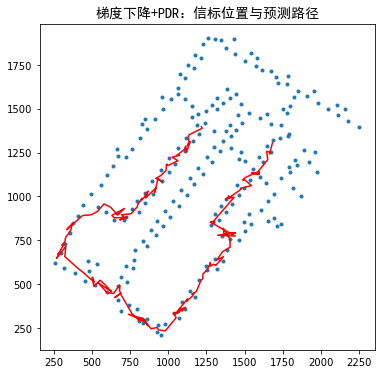

NameError: name 'res_loc_array_3p' is not defined

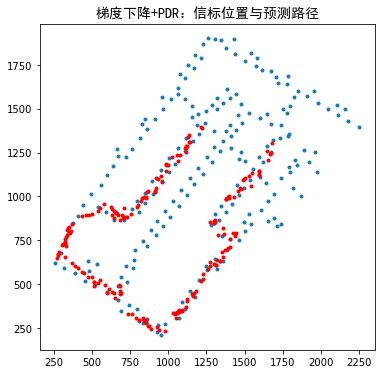

In [17]:
# 将step按RSS排序
def takeRSS(elem):
    return elem[3]
res_loc = [[0,0]]
n= 0 
for i in range(0,188):
    step = beacon_seq[n+i]
    cur_step = []
    for one_beacon in step:
        if GetXY(beacon_dic,one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2])) != -1 :
            cur_step.append(one_beacon)
            #print(one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2]))
            
    if len(cur_step) < 3:
        #print('点过少，跳过')
        x ,y = PDR(compass_seq[n+i],accelerometer_seq[n+i],time_seq_compass[n+i],time_seq_accelerometer[n+i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([res_loc[-1][0]+x*thita1,res_loc[-1][1]+y*thita2])
        #print(x*thita1,y*thita2,1)
        continue

    elif len(cur_step) == 3:
        distance = np.zeros(3)
        points = np.ones((3,2))
        distance[0] = cur_step[0][4]
        distance[1] = cur_step[1][4]
        distance[2] = cur_step[2][4]
        points[0] = GetXY(beacon_dic,cur_step[0][0].lower()+'_'+str(cur_step[0][1])+'_'+str(cur_step[0][2]))
        points[1] = GetXY(beacon_dic,cur_step[1][0].lower()+'_'+str(cur_step[1][1])+'_'+str(cur_step[1][2]))
        points[2] = GetXY(beacon_dic,cur_step[2][0].lower()+'_'+str(cur_step[2][1])+'_'+str(cur_step[2][2]))
        eval, loss = SGDS(points,distance)
        #print('1')
        x ,y = PDR(compass_seq[n+i],accelerometer_seq[n+i],time_seq_compass[n+i],time_seq_accelerometer[n+i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([eval[0]+x*thita1,eval[1]+y*thita2])
        #print(x*thita1,y*thita2)
    elif len(cur_step) >3:       
        cur_step.sort(key=takeRSS,reverse = True)       
        sort3 = cur_step[0:3]
        distance = np.zeros(3)
        points = np.zeros((3,2))
        distance[0] = sort3[0][4]
        distance[1] = sort3[1][4]
        distance[2] = sort3[2][4]
        points[0] = GetXY(beacon_dic,sort3[0][0].lower()+'_'+str(sort3[0][1])+'_'+str(sort3[0][2]))
        points[1] = GetXY(beacon_dic,sort3[1][0].lower()+'_'+str(sort3[1][1])+'_'+str(sort3[1][2]))
        points[2] = GetXY(beacon_dic,sort3[2][0].lower()+'_'+str(sort3[2][1])+'_'+str(sort3[2][2]))
        #print('2')
        eval, loss = SGDS(points,distance)
        x ,y = PDR(compass_seq[n+i],accelerometer_seq[n+i],time_seq_compass[n+i],time_seq_accelerometer[n+i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([eval[0]+x*thita1,eval[1]+y*thita2])
        #print(x*thita1,y*thita2)
res_loc.remove(res_loc[0])
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降+PDR：信标位置与预测路径", fontproperties=fontP)
res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r-')
plt.show()  
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降+PDR：信标位置与预测路径", fontproperties=fontP)
#res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r.')
plt.plot(res_loc_array_3p[:,0],res_loc_array_3p[:,1],'b.')
plt.show() 

In [286]:
compass_seq[3]

[330.18255615234375, 329.0830993652344, 327.94451904296875, 326.9335021972656]

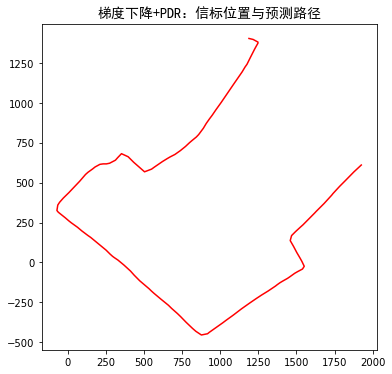

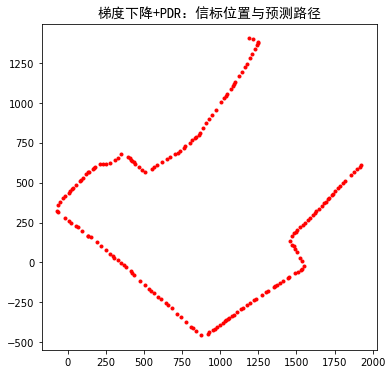

In [349]:
# 将step按RSS排序
def takeRSS(elem):
    return elem[3]
res_loc = [[res_loc_array_3p[0][0],res_loc_array_3p[0][1]]]
eval = [0,0]
for i in range(188):
    step = beacon_seq[i]
    cur_step = []
    for one_beacon in step:
        if GetXY(beacon_dic,one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2])) != -1 :
            cur_step.append(one_beacon)
            #print(one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2]))
            
    if len(cur_step) < 3:
        #print('点过少，跳过')
        x ,y = PDR(compass_seq[i],accelerometer_seq[i],time_seq_compass[i],time_seq_accelerometer[i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([res_loc[-1][0]+x*thita1,res_loc[-1][1]+y*thita2])
        continue

    elif len(cur_step) == 3:
        distance = np.zeros(3)
        points = np.ones((3,2))
        distance[0] = cur_step[0][4]
        distance[1] = cur_step[1][4]
        distance[2] = cur_step[2][4]
        points[0] = GetXY(beacon_dic,cur_step[0][0].lower()+'_'+str(cur_step[0][1])+'_'+str(cur_step[0][2]))
        points[1] = GetXY(beacon_dic,cur_step[1][0].lower()+'_'+str(cur_step[1][1])+'_'+str(cur_step[1][2]))
        points[2] = GetXY(beacon_dic,cur_step[2][0].lower()+'_'+str(cur_step[2][1])+'_'+str(cur_step[2][2]))
        eval, loss = SGDS(points,distance)
        #print('1')
        x ,y = PDR(compass_seq[i],accelerometer_seq[i],time_seq_compass[i],time_seq_accelerometer[i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([res_loc[-1][0]+x*thita1,res_loc[-1][1]+y*thita2])
    elif len(cur_step) >3:       
        cur_step.sort(key=takeRSS,reverse = True)       
        sort3 = cur_step[0:3]
        distance = np.zeros(3)
        points = np.zeros((3,2))
        distance[0] = sort3[0][4]
        distance[1] = sort3[1][4]
        distance[2] = sort3[2][4]
        points[0] = GetXY(beacon_dic,sort3[0][0].lower()+'_'+str(sort3[0][1])+'_'+str(sort3[0][2]))
        points[1] = GetXY(beacon_dic,sort3[1][0].lower()+'_'+str(sort3[1][1])+'_'+str(sort3[1][2]))
        points[2] = GetXY(beacon_dic,sort3[2][0].lower()+'_'+str(sort3[2][1])+'_'+str(sort3[2][2]))
        #print('2')
        eval, loss = SGDS(points,distance)
        x ,y = PDR(compass_seq[i],accelerometer_seq[i],time_seq_compass[i],time_seq_accelerometer[i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([res_loc[-1][0]+x*thita1,res_loc[-1][1]+y*thita2])

plt.figure(figsize=(6,6))
#plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降+PDR：信标位置与预测路径", fontproperties=fontP)
res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r-')
plt.show()  
plt.figure(figsize=(6,6))
#plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降+PDR：信标位置与预测路径", fontproperties=fontP)
#res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r.')
plt.show() 

# PDR导航+三点定位+kalman

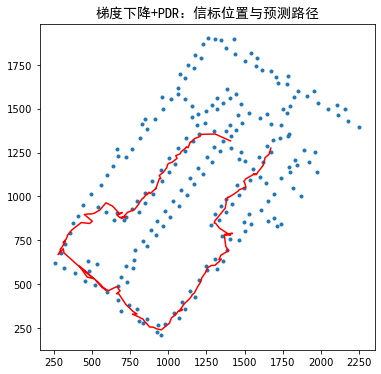

NameError: name 'res_loc_array_3p' is not defined

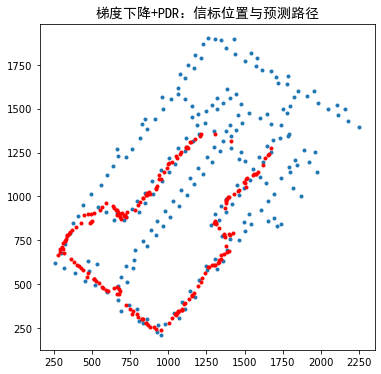

In [34]:
# 将step按RSS排序
def takeRSS(elem):
    return elem[3]
res_loc = [[0,0]]
n= 0 

evalkk=np.mat([[1637],[1219]])#当前卡尔曼估计值
evalkk1=np.mat([[1628],[1211]])#当前预测值
evalk1k1=np.mat([[0],[0]])#上一次卡尔曼估计值
Pkk=np.mat([[100,0],[0,100]])
Pkk1=np.mat([[100,0],[0,100]])
Pk1k1=np.mat([[100,0],[0,100]])
Q = np.mat([[500,0],[0,500]])
R = np.mat([[500,0],[0,500]])
kalman_T = []

for i in range(0,188):
    step = beacon_seq[n+i]
    cur_step = []
    for one_beacon in step:
        if GetXY(beacon_dic,one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2])) != -1 :
            cur_step.append(one_beacon)
            #print(one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2]))
            
    if len(cur_step) < 3:
        #print('点过少，跳过')
        x ,y = PDR(compass_seq[n+i],accelerometer_seq[n+i],time_seq_compass[n+i],time_seq_accelerometer[n+i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([res_loc[-1][0]+x*thita1,res_loc[-1][1]+y*thita2])
        continue
        evalkk1 = evalkk    #上一次的卡尔曼估计值为预测值
        Pkk1 = Pk1k1 + Q #此次协方差预测值
        Kk = np.dot(Pkk1,(Pkk1+R).I)#最优卡尔曼估计
        evalkk = evalkk1 + np.dot(Kk,np.mat([res_loc[-1][0]+x*thita1,res_loc[-1][1]+y*thita2]).T - evalkk1)#当前卡尔曼估计值
        Pkk1 = Pkk1 - np.dot(Kk,Pkk1)#当前卡尔曼协方差估计值
        
        res_loc.append([evalkk[0,0],evalkk[1,0]])
        #print(x*thita1,y*thita2,1)
        continue

    elif len(cur_step) == 3:
        distance = np.zeros(3)
        points = np.ones((3,2))
        distance[0] = cur_step[0][4]
        distance[1] = cur_step[1][4]
        distance[2] = cur_step[2][4]
        points[0] = GetXY(beacon_dic,cur_step[0][0].lower()+'_'+str(cur_step[0][1])+'_'+str(cur_step[0][2]))
        points[1] = GetXY(beacon_dic,cur_step[1][0].lower()+'_'+str(cur_step[1][1])+'_'+str(cur_step[1][2]))
        points[2] = GetXY(beacon_dic,cur_step[2][0].lower()+'_'+str(cur_step[2][1])+'_'+str(cur_step[2][2]))
        eval, loss = SGDS(points,distance,max_iter_count=100,axis='x',init=points[0])
        #print('1')
        x ,y = PDR(compass_seq[n+i],accelerometer_seq[n+i],time_seq_compass[n+i],time_seq_accelerometer[n+i])
        thita1 , thita2 = CalMapTrans()
        if 1:
            evalkk1 = evalkk    #上一次的卡尔曼估计值为预测值
            Pkk1 = Pk1k1 + Q #此次协方差预测值
            Kk = np.dot(Pkk1,(Pkk1+R).I)#最优卡尔曼估计
            evalkk = evalkk1 + np.dot(Kk,np.mat(eval+[x*thita1,y*thita2]).T - evalkk1)#当前卡尔曼估计值
            Pkk1 = Pkk1 - np.dot(Kk,Pkk1)#当前卡尔曼协方差估计值
            kalman_T.append([evalkk[0,0],evalkk[1,0]])
            T_obs.append(eval)
        res_loc.append([evalkk[0,0],evalkk[1,0]])
        #last_step = [x*thita1,y*thita2]
        #print(x*thita1,y*thita2)
    elif len(cur_step) >3:       
        cur_step.sort(key=takeRSS,reverse = True)       
        sort3 = cur_step[0:3]
        distance = np.zeros(3)
        points = np.zeros((3,2))
        distance[0] = sort3[0][4]
        distance[1] = sort3[1][4]
        distance[2] = sort3[2][4]
        points[0] = GetXY(beacon_dic,sort3[0][0].lower()+'_'+str(sort3[0][1])+'_'+str(sort3[0][2]))
        points[1] = GetXY(beacon_dic,sort3[1][0].lower()+'_'+str(sort3[1][1])+'_'+str(sort3[1][2]))
        points[2] = GetXY(beacon_dic,sort3[2][0].lower()+'_'+str(sort3[2][1])+'_'+str(sort3[2][2]))
        #print('2')
        eval, loss = SGDS(points,distance,max_iter_count=100,axis='x',init=points[0])
        x ,y = PDR(compass_seq[n+i],accelerometer_seq[n+i],time_seq_compass[n+i],time_seq_accelerometer[n+i])
        thita1 , thita2 = CalMapTrans()
        if 1:
            evalkk1 = evalkk    #上一次的卡尔曼估计值为预测值
            Pkk1 = Pk1k1 + Q #此次协方差预测值
            Kk = np.dot(Pkk1,(Pkk1+R).I)#最优卡尔曼估计
            evalkk = evalkk1 + np.dot(Kk,np.mat(eval+[x*thita1,y*thita2]).T - evalkk1)#当前卡尔曼估计值
            Pkk1 = Pkk1 - np.dot(Kk,Pkk1)#当前卡尔曼协方差估计值
            kalman_T.append([evalkk[0,0],evalkk[1,0]])
            T_obs.append(eval)
        res_loc.append([evalkk[0,0],evalkk[1,0]])
        
        #print(x*thita1,y*thita2)
res_loc.remove(res_loc[0])
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降+PDR：信标位置与预测路径", fontproperties=fontP)
res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r-')
plt.show()  
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降+PDR：信标位置与预测路径", fontproperties=fontP)
#res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r.')
plt.plot(res_loc_array_3p[:,0],res_loc_array_3p[:,1],'b.')
plt.show() 

In [2]:
a = [1,2]
x,y = a

In [9]:
import json
list_json = dict(zip(['a','b'],a))
(str(list_json))

"{'a': 1, 'b': 2}"